In [ ]:
import scipy.stats as sps
import numpy as np
import copy
import operator
import math
import random
from sympy import lambdify
from sympy import sympify
from sympy.parsing.sympy_parser import parse_expr
from sympy import simplify, cos, sin, exp
from sympy.abc import r, d, v, a, s

def Stability(d, v, r, a, s):
    """
    Stability function for data substitution
    """ 
    Stability = 17.8 + 0.013*s - 1.49*r - 12.6*(a/r) - 0.073*v**3 + 0.0019*r**3 + 0.00016*a**3 - 4.23*(a/r)**3 - 0.59*np.log(v) + 1.59*np.log(r)+\
                4.028*np.log(a/r) + 3.72*(10**(-26))*(np.exp(v))**2 + 1.207*(np.exp(a/r))**2 + 0.022*(np.log10(d))**2 + 0.11*(np.log10(a/r))**2
    return Stability


def gen_data(N, err):
    """
    Generates the data

    N (int): number of points generated
    err (float): std of the noise added to values of points

    return: (np.array of data, np.array of data with noise)
    """
    size = N
    samples = []
    results = []
    error = []
    a_1, b_1 = [0.84, 0.98]
    a_2, b_2 = [33.5, 34]
    a_3, b_3 = [0.05, 0.3]
    a_4, b_4 = [0.03, 0.2]
    a_5, b_5 = [0.45, 1]
    
    samples.append(np.random.normal((a_1+b_1)/2, (b_1 - (a_1 + b_1)/2)/3, size))
    samples.append(np.random.normal((a_2+b_2)/2, (b_2 - (a_2 + b_2)/2)/3, size))
    samples.append(np.random.normal((a_3+b_3)/2, (b_3 - (a_3 + b_3)/2)/3, size))
    samples.append(np.random.normal((a_4+b_4)/2, (b_4 - (a_4 + b_4)/2)/3, size))
    samples.append(np.random.normal((a_5+b_5)/2, (b_5 - (a_5 + b_5)/2)/3, size))
    for i in range(size):
      results.append(Stability(samples[0][i],samples[1][i],samples[2][i],samples[3][i],samples[4][i]))
    samples.append(results)
    samples = np.array(samples).transpose()
    for i in range(5):
      error.append(np.random.normal(0, err, size))
    error.append(np.zeros(size))
    error = np.array(error).transpose()
    return samples, samples + error

def gen_population(m, n_var):
    """
    Generates the start population

    m (int): number of expressions in population
    n_var (int): number of variables in generated expressions

    return: list of expressions 
    """ 
    population=[]
    for i in range(0,m):
      population.append(gen_expression(n_var))
    return population

def squared_error(expression):
    """
    Calculates the squared error of the formula from the calculated stability values

    expression (list): the list of str elements

    return: total squared error
    """ 
    expr = parse_expr(rpn_to_normal(expression).replace('^', '**'))
    expr=sympify(expr)
    f = lambdify([d,v,r,a,s], expr)
    return sum((res_s - f(d_s, v_s, r_s, a_s, s_s))**2)

def MSE(population, n_var):
    """
    Calculates the squared error of all expressions in population 

    population (list): the list of expressions
    n_var (int): number of variables in generated expressions

    return: list if squared error of each expression in population
    """ 
    y_diff = []
    Errors_mass = []
    for i in range(len(population)):
      check = False
      while check == False:
        try:
          if np.isinf(squared_error(population[i])) or np.isnan(squared_error(population[i])) or np.iscomplex(squared_error(population[i])):
            population[i] = gen_expression(n_var)
          else:
            y_diff.append(squared_error(population[i]))
            check = True
        except KeyError:
            population[i] = gen_expression(n_var)
        except OverflowError:
            population[i] = gen_expression(n_var)
    return y_diff
    
def gen_expression(n_var): 
    """
    Generates the expression

    n_var (int): number of variables in generated expressions

    return: list of str numbers and operations
    """ 
    insertion_count = random.randint(n_var + 1, n_var + 2)
    action =  np.random.choice(['+exp(','*', '/', '+', '-', '^','+log(', '+ln('], insertion_count - 1)
    expression = str(round(random.uniform(0,100),3)) 
    for a in action:
        number = (str(round(random.uniform(0,100),3))+'*')+np.random.choice(variables)
        expression += a +  str(number) 
        if a[-1] == '(':
            expression += ')'
    rpn_expression=rpn(expression)
    return rpn_expression

def selection(population, mse_errors, m):
    """
    Generates the start population

    population (list): the list of expressions
    mse_errors (list): the list of expressions errors
    m (int): the length of start population

    return: list of top-m functions with best squared error
    """ 
    sor = [[expression, error] for error, expression in sorted(zip(mse_errors, population))]
    k = sor[:m]
    return k

def crossover(population):
    """
    Makes the crossover of expressions

    population (list): the list of expressions

    return: concatenated list of received population and crossed population
    """ 
    pop = population
    new_expr = []
    for expr1, expr2 in zip(pop[0::2], pop[1::2]):
      new = exchange(expr1, expr2)
      new_expr.append(new[0])
      new_expr.append(new[1])
    new_population = population + new_expr
    return new_population

def exchange(rpn_1, rpn_2):
    """
    Makes the crossover of expressions

    rpn_1 (list): the expression 
    rpn_2 (list): the expression

    return: tuple of expressions with exchanged undertrees
    """ 
    rpn_1_cop = list(rpn_1)
    rpn_2_cop = list(rpn_2)
    utrees1 = undertrees(rpn_1)
    utrees2 = undertrees(rpn_2)
    ind_1 = random.randint(0,len(utrees1[1])-2)# we don't want to take the full undertree
    ind_2 = random.randint(0,len(utrees2[1])-2)
    tree1 = utrees1[1][ind_1]
    tree2 = utrees2[1][ind_2]
    rpn_1_cop[utrees1[0][ind_1]: utrees1[0][ind_1] + len(tree1)] = tree2
    rpn_2_cop[utrees2[0][ind_2]: utrees2[0][ind_2] +len(tree2)] = tree1
    return rpn_1_cop, rpn_2_cop

def undertrees(ax):
    """
    Finds all undertrees of expression

    ax (list): the expression 

    return: tuple of list of indexes, where trees start and list of trees
    """ 
    stack=[]
    stack_tree=[]
    indexes=[]
    if len(ax) == 1:
      stack_tree.append(ax)
      indexes.append(0)
    else:
      for i in range(len(ax)):
          if ax[i] in oper1:
            stack.append(stack[-2]+stack[-1]+[ax[i]])
            stack.remove(stack[-3])
            stack.remove(stack[-2])
            stack_tree.append(stack[-1])
            indexes.append(i-len(stack[-1])+1)
          elif ax[i] in oper2:
            stack.append(stack[-1]+[ax[i]])
            stack.remove(stack[-2])
            stack_tree.append(stack[-1])
            indexes.append(i-len(stack[-1])+1)
          else:
            stack.append([ax[i]])
    return (indexes,stack_tree)

def rpn(s):
    """
    Finds the reverse polish notation of expression

    s (str): the expression 

    return: list of str expression elements in reverse polish notation
    """ 
    s = s.replace('**', '^')
    lex=parse(s)
    s2=[]
    r=[]
    unary = ['exp', 'log', 'ln']
    oper=["+","-","*","/","(",")",'^']
    temp_oper = ''
    skip = 0
    for num, a in enumerate(lex):
        if skip!=0:
            skip-=1
            continue
        if a=="(":
            s2=[a]+s2
        elif a in oper:
            if s2==[]:
                s2=[a]
            elif a==")":
                while(True):
                    q=s2[0]
                    s2=s2[1:]
                    if q=="(":
                        break
                    r+=[q]
            elif prty(s2[0]) < prty(a):
                s2=[a]+s2
            else:
                while(True):
                    if s2==[]:
                        break
                    q=s2[0]
                    r+=[q]
                    s2=s2[1:]
                    if prty(q)==prty(a):
                        break
                s2=[a]+s2
        elif a in unary:
          temp_oper = a
          ind = lex.index(')', num)
          arg = rpn(''.join(lex[num+1:ind+1]))
          r+=arg
          r+=[temp_oper]
          skip = ind - num          
        else:
            r+=[a]
    while(s2 != []):
        q=s2[0]
        r+=[q]
        s2=s2[1:]
    return r
  
def prty(o):
    """
    Defines the priority of operators
    """
    if o=="+" or o=="-":
        return 1
    elif o=="*" or o=="/" or o=="^":
        return 2
    elif o=="(":
        return 0

def parse(s):
    """
    Parses the expressions using operators
    """
    delims=["+","-","*","/","(",")", '^']
    lex=[]
    tmp=""
    for a in s:
        if a != " ":
            if a in delims:
                if tmp != "":
                    lex+=[tmp]
                lex+=[a]
                tmp=""
            else:
                tmp+=a
    if tmp != "":
        lex+=[tmp]
    return lex
    
def rpn_calc(srt1):
    """
    Сalculates the value of an expression written in reverse Polish notation
    """
    srt = copy.deepcopy(srt1)
    OPERATORS = {'+': (2, operator.add), '-': (2, operator.sub), '*': (2, operator.mul), '/': (2, operator.truediv), 'exp': (1, math.exp), 'log': (1, math.log10), 'ln': (1, math.log), '^': (2, math.pow)}
    oper=['exp', '*', '/', '+', '-', '^','log', 'ln']
    stack = []
    for i in srt:
        if i not in oper:
            stack.append(i)
        else:
            if OPERATORS[i][0] == 1:
                cnt1 = stack.pop()
                op = OPERATORS[i][1]
                try:
                  stack.append(str(OPERATORS[i][1](float(cnt1))))
                except ValueError:
                 return False
                except OverflowError:
                  return False
                except ZeroDivisionError:
                  return False
            else:
                cnt1, cnt2 = stack.pop(), stack.pop()
                try:
                  stack.append(str(OPERATORS[i][1](float(cnt2), float(cnt1))))
                except ValueError:
                  return False
                except OverflowError:
                  return False
                except ZeroDivisionError:
                  return False
                
    return stack.pop()  


def mutation(population):
    """
    For each expression with different probabilities does:
    1) Replacing operator with a random one 
    2) Deleting a non-leaf node 
    3) Replacing a subtree with a random one  
    """ 
    for i in range(len(population)):
      if len(population[i])>70:
        population[i]=gen_expression(8)
    for i in range(1,len(population)): # iterating on each representative
      rand_value = random.randint(0,100)
      if rand_value > 70: # 70% - probability of mutation of the expression
        rand_value_2 = random.randint(0,100)
        if rand_value_2 >= 80: # 20% - probability of random operator replacement
          j=random.randint(0,len(population[i])-1)
          temp=False
          while temp==False:
            if population[i][j] in ['*', '/', '+', '-', '^']:
                population[i][j]=np.random.choice(['*', '/', '+', '-', '^'],1)[0]
                temp=True
            elif population[i][j] in ['exp','log', 'ln']:
                population[i][j]=np.random.choice(['exp','log', 'ln'],1)[0]
                temp=True
            else: j=random.randint(0,len(population[i])-1)
        elif rand_value_2<80 and rand_value_2>=50: # 30% - probability of deleting a non-leaf node 
          j=random.randint(0,len(population[i])-4)
          while population[i][j] not in ['*', '/', '+', '-', '^','exp','log', 'ln']:
            j=random.randint(0,len(population[i])-4)
          for p in range(j,0,-1):
            if population[i][p] in oper:
              if population[i][p-1] in oper2:
                population[i].pop(p-1)
        elif rand_value_2 < 50: # 50% - probability of replacing a subtree with a random one 
          expr = population[i]
          try:
            utrees = undertrees(expr)
            r_idx = random.randint(0,len(utrees[1])//2)
            tree = utrees[1][r_idx]
            t_idx = utrees[0][r_idx]
            k = sum([1 for el in tree if el not in oper])
            expr[t_idx : t_idx + len(tree)] = gen_expression(k)
          except IndexError:
            continue  
              
def rpn_to_normal(expression):
    """
    Translates an expression from the reverse polish notation to the normal
    """ 
    srt = list(expression)
    OPERATORS = {'+': (2, operator.add), '-': (2, operator.sub), '*': (2, operator.mul), '/': (2, operator.truediv), 'exp': (1, math.exp), 'log': (1, math.log10), 'ln': (1, math.log), '^': (2, math.pow)}
    oper=['exp', '*', '/', '+', '-', '^','log', 'ln']
    stack = []
    for i in srt:
        if i not in oper:
            stack.append(i)
        else:
            if OPERATORS[i][0] == 1:
                cnt1 = stack.pop()
                try:
                  stack.append( i + '(' + str(cnt1) + ')')
                except ValueError:
                 return False
                except OverflowError:
                  return False
            else:
                cnt1, cnt2 = stack.pop(), stack.pop()
                try:
                  stack.append('(' + str(cnt2) + ')' + i + '(' + str(cnt1) + ')')
                except ValueError:
                  return False
                except OverflowError:
                  return False
    return stack.pop() 

In [ ]:
from sympy.strategies.rl import sort
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

variables=["d","v","r","a","s"]
oper=['*', '/', '+', '-', '^','exp','log', 'ln']
oper1=['*', '/', '+', '-', '^']
oper2=['exp','log', 'ln']

m = 100 # population size
n = 25 # number of data points
n_var = 8 # the number of variables in the expression
dispersia = 0.01
M=0
epsilon = 1000
min_mse_error = 2000
errors_list = []

samples, samples_err = gen_data(n, dispersia)
population = gen_population(m, n_var)
d_s = samples[:, 0]
v_s = samples[:, 1]
r_s = samples[:, 2]
a_s = samples[:, 3]
s_s = samples[:, 4]
res_s=samples[:, 5]
while min_mse_error > epsilon:
  crossed_population = crossover(population)
  mutation(crossed_population)
  selected = selection(crossed_population, MSE(crossed_population, n_var), m)
  population = [pair[0] for pair in selected]
  min_mse_error = selected[0][1]
  final_expr = selected[0][0]
  errors_list.append(min_mse_error)
  M += 1
  print(' Iteration =',M,'\n','Answer =',final_expr,'\n','Error =',min_mse_error,'\n','Len =',len(final_expr),'\n','-------------------------','\n')

 Iteration = 1 
 Answer = ['67.028', '88.316', 'a', '*', '29.772', '/', 's', '*', '99.552', '*', 'v', '*', '-', '28.458', 'a', '*', 'ln', '27.545', '/', 's', '*', '44.973', '*', 'a', '*', '+', '90.454', 'd', '*', 'log', '+', '97.339', 'd', '*', '-'] 
 Error = 1587310.414187096 
 Len = 35 
 ------------------------- 

 Iteration = 2 
 Answer = ['67.028', '88.316', 'a', '*', '29.772', '/', 's', '*', '99.552', '*', 'v', '*', '-', '28.458', 'a', '*', 'ln', '27.545', '/', 's', '*', '44.973', '*', 'a', '*', '+', '90.454', 'd', '*', 'log', '+', '97.339', 'd', '*', '-'] 
 Error = 1587310.414187096 
 Len = 35 
 ------------------------- 

 Iteration = 3 
 Answer = ['67.028', '88.316', 'a', '*', '29.772', '/', 's', '*', '99.552', '*', 'v', '*', '-', '28.458', 'a', '*', 'ln', '27.545', '/', 's', '*', '44.973', '*', 'a', '*', '+', '90.454', 'd', '*', 'log', '+', '97.339', 'd', '*', '-'] 
 Error = 1587310.414187096 
 Len = 35 
 ------------------------- 

 Iteration = 4 
 Answer = ['67.028', '88.31

IndexError: ignored

In [ ]:
def get_sympy_formula(final_expr):
  temp = rpn_to_normal(final_expr).replace('^','**')
  temp = simplify(parse_expr(temp))
  return temp
  
get_sympy_formula(final_expr)

1.5549272815262*v*(d - 1.5549272815262*v + log((129.506*a*exp(43.47*r) + 1751.115379*s*(896.293632*r + log(a) + 4.04433115018997))/a) + 24.153) - 44.438*v + 1.5549272815262

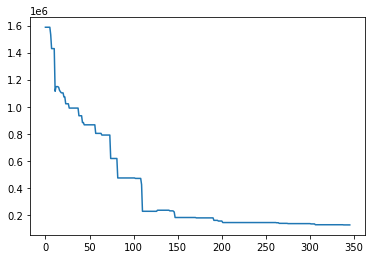

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(errors_list))], errors_list);

In [ ]:
def count_formula(expression):
  expr=sympify(expression)
  f = lambdify([d,v,r,a,s], expr)
  return f(d_s,v_s,r_s,s_s,s_s)

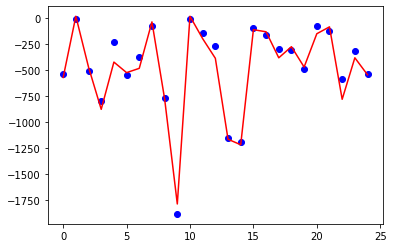

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = samples_err[:, 5]
x = [i for i in range(len(samples_err))]
stab= count_formula(str(get_sympy_formula(final_expr)))

plt.plot(x, y, 'bo', x, stab, 'r-')

- On the horizontal axis, the number of the point from the generated data is postponed
- On the y-axis, the stability values at this point are marked with red dots according to an approximate formula, and the real values at these points are marked with blue dots

# Checking formula on new data

In [ ]:
samples_2, samples_err_2 = (n, dispersia)

In [ ]:
d_s_2 = samples_2[:, 0]
v_s_2 = samples_2[:, 1]
r_s_2 = samples_2[:, 2]
a_s_2 = samples_2[:, 3]
s_s_2 = samples_2[:, 4]
res_s_2=samples_2[:, 5]

In [ ]:
def count_formula_2(expression):
  expr=sympify(expression)
  f = lambdify([d,v,r,a,s], expr)
  return f(d_s_2,v_s_2,r_s_2,s_s_2,s_s_2)

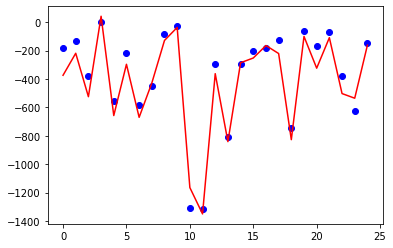

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = samples_err_2[:, 5]
x = [i for i in range(len(samples_err_2))]
stab= count_formula_2(str(get_sympy_formula(final_expr)))

plt.plot(x, y, 'bo', x, stab, 'r-')

In [ ]:
sum((y - stab)**2)

193543.97743192234